In [13]:
import numpy as np
import matplotlib.pyplot as plt
import cebra
from cebra import CEBRA 
from cebra.datasets import init as dataset_init

In [14]:
# 加载包含所有数据的数据集 (active + passive)
dataset = dataset_init("area2-bump")
# Active数据集
pos_dataset_active = dataset_init("area2-bump-pos-active")
target_dataset_active = dataset_init("area2-bump-target-active")
posdir_dataset_active = dataset_init("area2-bump-posdir-active")
# Passive数据集
pos_dataset_passive = dataset_init("area2-bump-pos-passive")
target_dataset_passive = dataset_init("area2-bump-target-passive")
posdir_dataset_passive = dataset_init("area2-bump-posdir-passive")

# 数据集验证函数
def validate_dataset(dataset, name):
    """验证数据集基本信息"""
    print(f"\n{name} Dataset Info:")
    print(f"Total length: {len(dataset)}")
    if hasattr(dataset, 'neural'):
        print(f"Neural data shape: {dataset.neural.shape}")
    if hasattr(dataset, 'continuous_index') and dataset.continuous_index is not None:
        print(f"Continuous labels shape: {dataset.continuous_index.shape}")
    if hasattr(dataset, 'discrete_index') and dataset.discrete_index is not None:
        print(f"Discrete labels shape: {dataset.discrete_index.shape}")

# 添加验证代码，验证所有六个数据集
validate_dataset(dataset, "Base")
# Active数据集验证
validate_dataset(pos_dataset_active, "Position (Active)")
validate_dataset(target_dataset_active, "Target (Active)")
validate_dataset(posdir_dataset_active, "Position-Direction (Active)")
# Passive数据集验证
validate_dataset(pos_dataset_passive, "Position (Passive)")
validate_dataset(target_dataset_passive, "Target (Passive)")
validate_dataset(posdir_dataset_passive, "Position-Direction (Passive)")


Base Dataset Info:
Total length: 115800
Neural data shape: torch.Size([115800, 65])
Continuous labels shape: torch.Size([115800, 2])
Discrete labels shape: torch.Size([115800])

Position (Active) Dataset Info:
Total length: 115800
Neural data shape: torch.Size([115800, 65])
Continuous labels shape: torch.Size([115800, 2])

Target (Active) Dataset Info:
Total length: 115800
Neural data shape: torch.Size([115800, 65])
Discrete labels shape: torch.Size([115800])

Position-Direction (Active) Dataset Info:
Total length: 115800
Neural data shape: torch.Size([115800, 65])
Continuous labels shape: torch.Size([115800, 2])
Discrete labels shape: torch.Size([115800])

Position (Passive) Dataset Info:
Total length: 102600
Neural data shape: torch.Size([102600, 65])
Continuous labels shape: torch.Size([102600, 2])

Target (Passive) Dataset Info:
Total length: 102600
Neural data shape: torch.Size([102600, 65])
Discrete labels shape: torch.Size([102600])

Position-Direction (Passive) Dataset Info:
T

In [15]:
# 修改为直接使用分离的数据集
# Active数据
active_neural = pos_dataset_active.neural
active_pos = pos_dataset_active.continuous_index
active_target = target_dataset_active.discrete_index

# Passive数据
passive_neural = pos_dataset_passive.neural
passive_pos = pos_dataset_passive.continuous_index
passive_target = target_dataset_passive.discrete_index

# 打印分离数据集形状
print(f"Active neural data shape: {active_neural.shape}")
print(f"Passive neural data shape: {passive_neural.shape}")
print(f"Active position labels shape: {active_pos.shape}")
print(f"Passive position labels shape: {passive_pos.shape}")
print(f"Active target labels shape: {active_target.shape}")
print(f"Passive target labels shape: {passive_target.shape}")

Active neural data shape: torch.Size([115800, 65])
Passive neural data shape: torch.Size([102600, 65])
Active position labels shape: torch.Size([115800, 2])
Passive position labels shape: torch.Size([102600, 2])
Active target labels shape: torch.Size([115800])
Passive target labels shape: torch.Size([102600])


In [16]:
# 创建模型函数
def create_cebra_model(output_dim=3, max_iter=15000):
    return CEBRA(
        model_architecture='offset10-model',
        batch_size=512,
        learning_rate=0.0001,
        temperature=1,
        output_dimension=output_dim,
        max_iterations=max_iter,
        distance='cosine',
        conditional='time_delta',
        device='cuda_if_available',
        verbose=True,
        time_offsets=10
    )

# 创建位置模型
active_pos_model = create_cebra_model()
passive_pos_model = create_cebra_model()

# 创建目标方向模型
active_target_model = create_cebra_model()
passive_target_model = create_cebra_model()

In [17]:
# 训练 Active 位置模型
print("Training Active Position Model...")
active_pos_model.fit(active_neural, active_pos.numpy())
active_pos_embedding = active_pos_model.transform(active_neural)

# 训练 Passive 位置模型
print("\nTraining Passive Position Model...")
passive_pos_model.fit(passive_neural, passive_pos.numpy())
passive_pos_embedding = passive_pos_model.transform(passive_neural)

Training Active Position Model...


pos: -0.8632 neg:  6.4210 total:  5.5578 temperature:  1.0000: 100%|██████████| 15000/15000 [02:28<00:00, 101.14it/s]



Training Passive Position Model...


pos: -0.6943 neg:  6.4976 total:  5.8034 temperature:  1.0000: 100%|██████████| 15000/15000 [02:15<00:00, 110.31it/s]


In [18]:
# 训练 Active 目标方向模型
print("Training Active Target Model...")
active_target_model.fit(active_neural, active_target.numpy())
active_target_embedding = active_target_model.transform(active_neural)

# 训练 Passive 目标方向模型
print("\nTraining Passive Target Model...")
passive_target_model.fit(passive_neural, passive_target.numpy())
passive_target_embedding = passive_target_model.transform(passive_neural)

Training Active Target Model...


pos: -0.7279 neg:  6.4445 total:  5.7165 temperature:  1.0000: 100%|██████████| 15000/15000 [02:16<00:00, 109.98it/s]



Training Passive Target Model...


pos: -0.4853 neg:  6.4331 total:  5.9478 temperature:  1.0000: 100%|██████████| 15000/15000 [02:15<00:00, 110.49it/s]


In [19]:
def plot_embeddings(active_emb, passive_emb, active_labels, passive_labels, title, cmap='seismic', 
                   vmin=None, vmax=None, figsize=(12, 5), alpha=0.7, point_size=0.05):
    """绘制对比可视化图
    
    Args:
        active_emb: Active数据的嵌入
        passive_emb: Passive数据的嵌入
        active_labels: Active数据的标签（用于着色）
        passive_labels: Passive数据的标签（用于着色）
        title: 图表标题
        cmap: 颜色映射
        vmin, vmax: 颜色映射的最小值和最大值
        figsize: 图表大小
        alpha: 点的透明度
        point_size: 点的大小
    """
    fig = plt.figure(figsize=figsize)
    plt.suptitle(f'CEBRA {title} Embeddings: Active vs Passive', fontsize=20)
    
    # Active
    ax = plt.subplot(121, projection='3d')
    ax.set_title('Active Trials', fontsize=15)
    scatter = ax.scatter(active_emb[:, 0],
                        active_emb[:, 1],
                        active_emb[:, 2],
                        c=active_labels,
                        cmap=cmap,
                        s=point_size,
                        alpha=alpha,
                        vmin=vmin,
                        vmax=vmax)
    ax.axis('off')
    
    # Passive
    ax = plt.subplot(122, projection='3d')
    ax.set_title('Passive Trials', fontsize=15)
    scatter = ax.scatter(passive_emb[:, 0],
                        passive_emb[:, 1],
                        passive_emb[:, 2],
                        c=passive_labels,
                        cmap=cmap,
                        s=point_size,
                        alpha=alpha,
                        vmin=vmin,
                        vmax=vmax)
    ax.axis('off')
    
    cbar = plt.colorbar(scatter)
    if title == 'Target Direction':
        cbar.set_label('Direction')
    else:
        cbar.set_label('Position (cm)')
    
    plt.tight_layout()
    plt.show()
    
    return fig

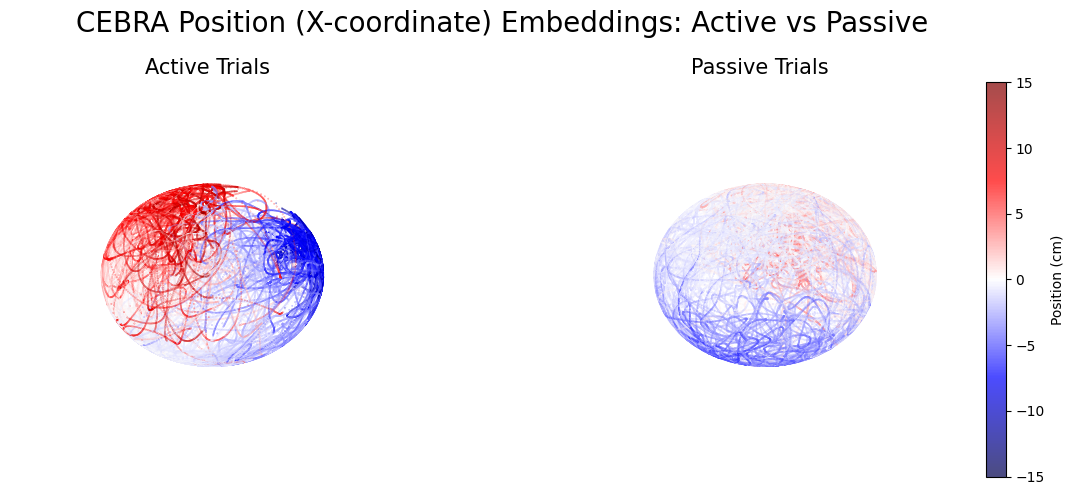

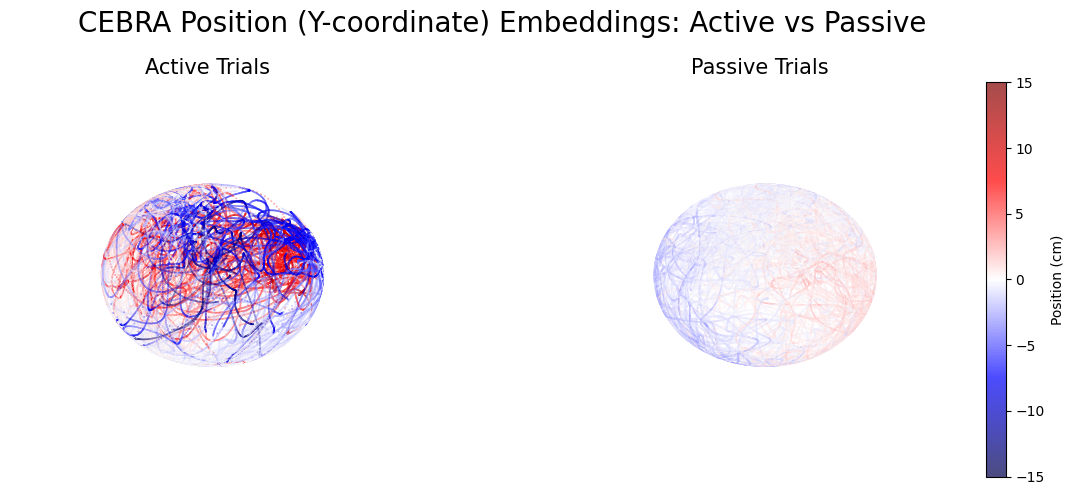

In [20]:
# 绘制位置模型的嵌入结果（使用x坐标着色）
position_fig = plot_embeddings(
    active_pos_embedding,
    passive_pos_embedding,
    active_pos[:, 0],  # 使用x坐标作为颜色
    passive_pos[:, 0],
    'Position (X-coordinate)',
    cmap='seismic',
    vmin=-15,
    vmax=15
)
# 绘制位置模型的嵌入结果（使用y坐标着色）
position_y_fig = plot_embeddings(
    active_pos_embedding,
    passive_pos_embedding,
    active_pos[:, 1],  # 使用y坐标作为颜色
    passive_pos[:, 1],
    'Position (Y-coordinate)',
    cmap='seismic',
    vmin=-15,
    vmax=15
)

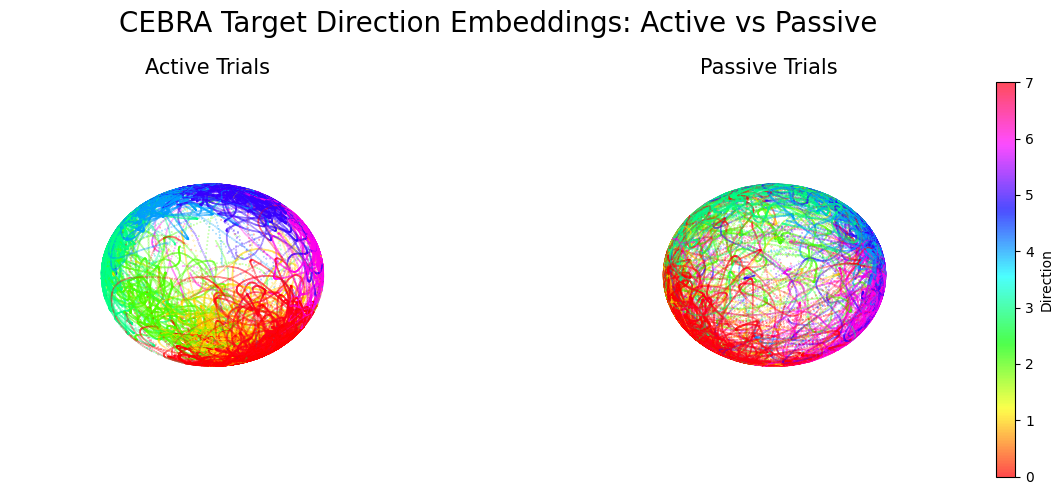

In [21]:
# 绘制目标方向模型的嵌入结果
target_fig = plot_embeddings(
    active_target_embedding,
    passive_target_embedding,
    active_target.flatten(),
    passive_target.flatten(),
    'Target Direction',
    cmap='hsv',
    vmin=0,
    vmax=7  # 8个方向，索引0-7
)

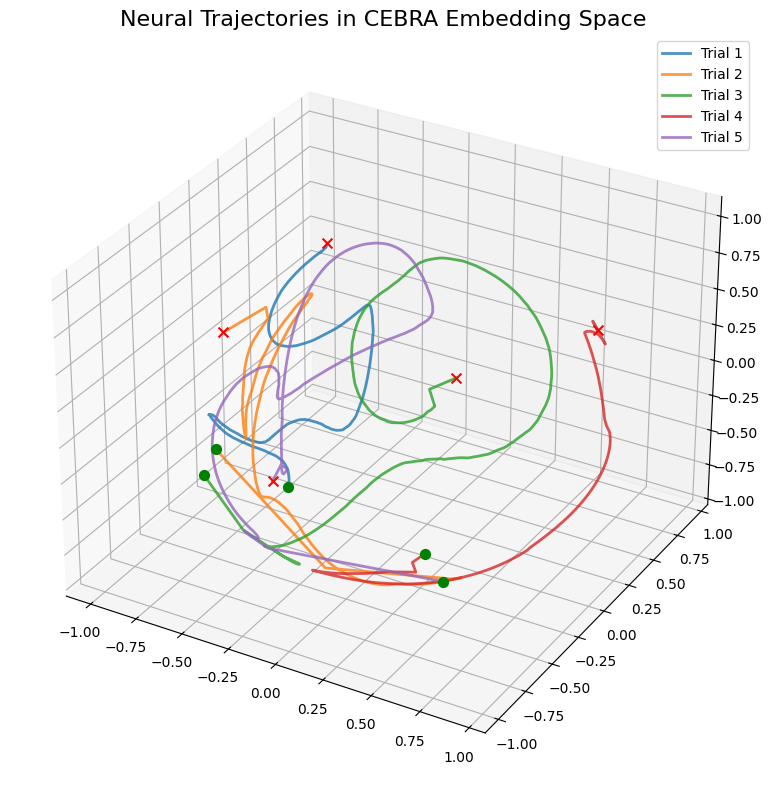

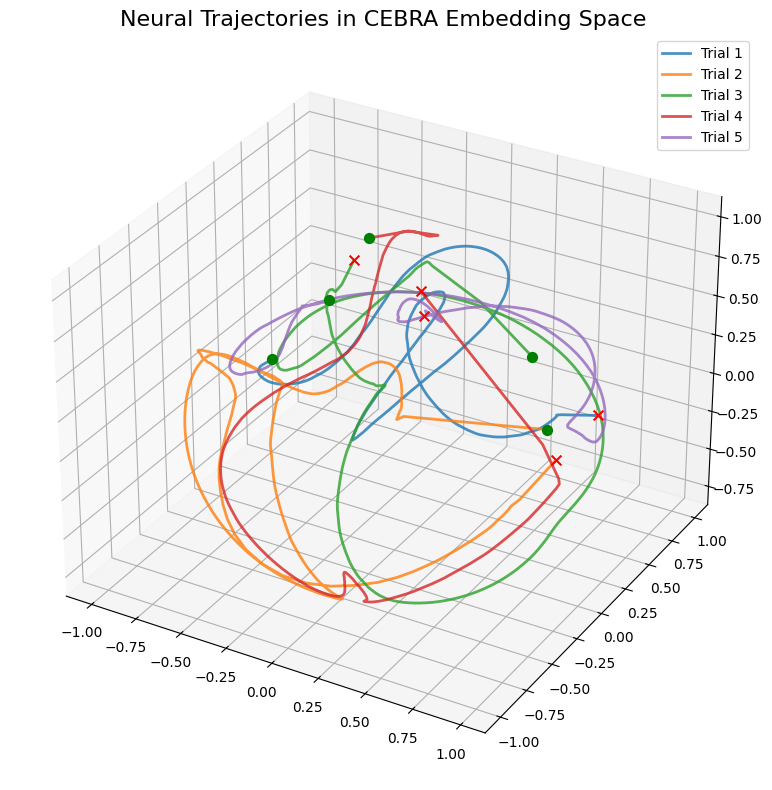

In [22]:
def plot_trajectories(embedding, trial_length=600, n_trials=5, figsize=(10, 8)):
    """在嵌入空间中可视化神经轨迹
    
    Args:
        embedding: 嵌入结果
        trial_length: 每个trial的长度
        n_trials: 要可视化的trial数量
        figsize: 图表大小
    """
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    
    # 将嵌入重塑为(n_trials, trial_length, 3)
    trials = embedding[:n_trials*trial_length].reshape(-1, trial_length, 3)
    
    # 为每个trial绘制轨迹
    for i in range(n_trials):
        trial = trials[i]
        ax.plot(trial[:, 0], trial[:, 1], trial[:, 2], 
                linewidth=2, alpha=0.8, label=f'Trial {i+1}')
        
        # 标记起点和终点
        ax.scatter(trial[0, 0], trial[0, 1], trial[0, 2], 
                  c='green', s=50, marker='o', label='_nolegend_')
        ax.scatter(trial[-1, 0], trial[-1, 1], trial[-1, 2], 
                  c='red', s=50, marker='x', label='_nolegend_')
    
    ax.set_title('Neural Trajectories in CEBRA Embedding Space', fontsize=16)
    ax.legend()
    plt.tight_layout()
    plt.show()
    
    return fig

# 绘制Active位置模型的轨迹
active_trajectories = plot_trajectories(active_pos_embedding)

# 绘制Passive位置模型的轨迹
passive_trajectories = plot_trajectories(passive_pos_embedding)

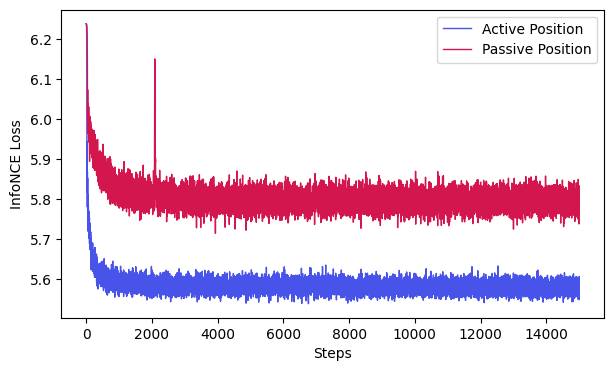

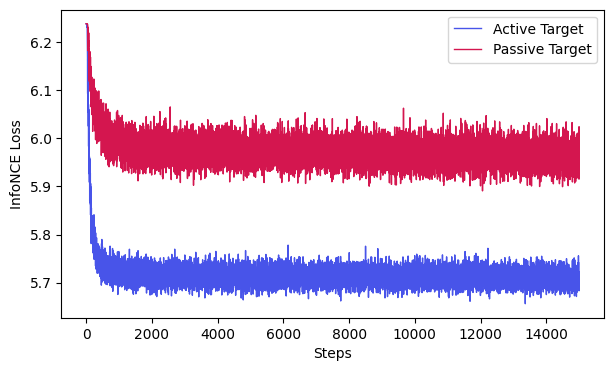

In [23]:
# 比较Active和Passive数据的模型性能
import cebra

# 比较位置模型
pos_comparison = cebra.compare_models(
    [active_pos_model, passive_pos_model], 
    ["Active Position", "Passive Position"]
)

# 比较目标方向模型
target_comparison = cebra.compare_models(
    [active_target_model, passive_target_model], 
    ["Active Target", "Passive Target"]
)

In [24]:
def compute_model_consistency(model1, model2, data1, data2, labels1=None, labels2=None, n_runs=2):
    """计算两个模型之间的一致性得分"""
    
    def preprocess_labels(labels):
        """预处理标签"""
        if labels is None:
            return None
        # 确保是1D数组
        if len(labels.shape) > 1:
            labels = labels[:, 0]
        # 转换为numpy数组
        if not isinstance(labels, np.ndarray):
            labels = np.array(labels)
        return labels

    def normalize_labels(labels1, labels2):
        """标准化标签"""
        # 计算全局统计量
        all_labels = np.concatenate([labels1, labels2])
        mean = np.mean(all_labels)
        std = np.std(all_labels)
        
        # Z-score标准化
        labels1_norm = (labels1 - mean) / (std + 1e-8)
        labels2_norm = (labels2 - mean) / (std + 1e-8)
        
        return labels1_norm, labels2_norm

    # 预处理标签
    labels1_proc = preprocess_labels(labels1)
    labels2_proc = preprocess_labels(labels2)
    
    embeddings_runs1 = []
    embeddings_runs2 = []
    
    # 多次运行每个模型
    for i in range(n_runs):
        print(f"Run {i+1}/{n_runs} for model1...")
        embeddings_runs1.append(model1.fit_transform(data1, labels1))
        print(f"Run {i+1}/{n_runs} for model2...")
        embeddings_runs2.append(model2.fit_transform(data2, labels2))
    
    # 计算运行间的一致性
    scores_runs1, pairs_runs1, ids_runs1 = cebra.sklearn.metrics.consistency_score(
        embeddings=embeddings_runs1,
        between="runs"
    )
    
    scores_runs2, pairs_runs2, ids_runs2 = cebra.sklearn.metrics.consistency_score(
        embeddings=embeddings_runs2,
        between="runs"
    )
    
    # 计算数据集间的一致性
    if labels1_proc is not None and labels2_proc is not None:
        try:
            # 标准化标签
            labels1_norm, labels2_norm = normalize_labels(labels1_proc, labels2_proc)
            
            # 检查标签分布
            print("\nLabel distribution statistics:")
            print(f"Labels1 - mean: {np.mean(labels1_norm):.3f}, std: {np.std(labels1_norm):.3f}")
            print(f"Labels2 - mean: {np.mean(labels2_norm):.3f}, std: {np.std(labels2_norm):.3f}")
            
            scores_datasets, pairs_datasets, ids_datasets = cebra.sklearn.metrics.consistency_score(
                embeddings=[embeddings_runs1[0], embeddings_runs2[0]],
                labels=[labels1_norm, labels2_norm],
                dataset_ids=["Active", "Passive"],
                between="datasets",
                num_discretization_bins=20  # 减少bin数量
            )
        except Exception as e:
            print(f"\nError in dataset consistency calculation: {e}")
            print("Attempting alternative binning strategy...")
            try:
                # 尝试使用分位数离散化
                from sklearn.preprocessing import KBinsDiscretizer
                discretizer = KBinsDiscretizer(n_bins=20, encode='ordinal', strategy='quantile')
                labels_combined = np.concatenate([labels1_norm, labels2_norm])
                discretizer.fit(labels_combined.reshape(-1, 1))
                
                labels1_disc = discretizer.transform(labels1_norm.reshape(-1, 1)).flatten()
                labels2_disc = discretizer.transform(labels2_norm.reshape(-1, 1)).flatten()
                
                scores_datasets, pairs_datasets, ids_datasets = cebra.sklearn.metrics.consistency_score(
                    embeddings=[embeddings_runs1[0], embeddings_runs2[0]],
                    labels=[labels1_disc, labels2_disc],
                    dataset_ids=["Active", "Passive"],
                    between="datasets"
                )
            except Exception as e2:
                print(f"Alternative binning also failed: {e2}")
                scores_datasets, pairs_datasets, ids_datasets = None, None, None
    else:
        scores_datasets, pairs_datasets, ids_datasets = None, None, None
    
    return {
        'runs1': (scores_runs1, pairs_runs1, ids_runs1),
        'runs2': (scores_runs2, pairs_runs2, ids_runs2),
        'datasets': (scores_datasets, pairs_datasets, ids_datasets),
        'embeddings1': embeddings_runs1[0],
        'embeddings2': embeddings_runs2[0]
    }

In [25]:
# 确保数据是正确的numpy数组
active_pos_np = active_pos.numpy() if hasattr(active_pos, 'numpy') else active_pos
passive_pos_np = passive_pos.numpy() if hasattr(passive_pos, 'numpy') else passive_pos

active_pos_1d = active_pos_np[:, 0] if len(active_pos_np.shape) > 1 else active_pos_np
passive_pos_1d = passive_pos_np[:, 0] if len(passive_pos_np.shape) > 1 else passive_pos_np

# 同样处理target数据
active_target_np = active_target.numpy() if hasattr(active_target, 'numpy') else active_target
passive_target_np = passive_target.numpy() if hasattr(passive_target, 'numpy') else passive_target

active_target_1d = active_target_np[:, 0] if len(active_target_np.shape) > 1 else active_target_np
passive_target_1d = passive_target_np[:, 0] if len(passive_target_np.shape) > 1 else passive_target_np

# 目标标签应该已经是1D的，但我们确保一下
if len(active_target.shape) > 1:
    active_target_1d = active_target[:, 0]
else:
    active_target_1d = active_target

if len(passive_target.shape) > 1:
    passive_target_1d = passive_target[:, 0]
else:
    passive_target_1d = passive_target

# 计算位置模型的一致性（Active vs Passive）
pos_consistency = compute_model_consistency(
    active_pos_model,
    passive_pos_model,
    active_neural,
    passive_neural,
    active_pos_1d,  # 已经确保是numpy数组
    passive_pos_1d, # 已经确保是numpy数组
    n_runs=2
)

# 计算目标方向模型的一致性
target_consistency = compute_model_consistency(
    active_target_model,
    passive_target_model,
    active_neural,
    passive_neural,
    active_target_1d,
    passive_target_1d,
    n_runs=2
)

Run 1/2 for model1...


pos: -0.7458 neg:  6.5220 total:  5.7762 temperature:  1.0000: 100%|██████████| 15000/15000 [02:13<00:00, 112.10it/s]


Run 1/2 for model2...


pos: -0.6913 neg:  6.5892 total:  5.8979 temperature:  1.0000: 100%|██████████| 15000/15000 [02:15<00:00, 110.32it/s]


Run 2/2 for model1...


pos: -0.7474 neg:  6.4901 total:  5.7427 temperature:  1.0000: 100%|██████████| 15000/15000 [02:15<00:00, 111.05it/s]


Run 2/2 for model2...


pos: -0.6571 neg:  6.5756 total:  5.9185 temperature:  1.0000: 100%|██████████| 15000/15000 [02:14<00:00, 111.20it/s]



Label distribution statistics:
Labels1 - mean: -0.005, std: 1.260
Labels2 - mean: 0.006, std: 0.581

Error in dataset consistency calculation: Digitalized labels does not have elements close enough to bin index 1. The bin index should be in the range of the labels values.
Attempting alternative binning strategy...
Alternative binning also failed: Digitalized labels does not have elements close enough to bin index 24. The bin index should be in the range of the labels values.
Run 1/2 for model1...


pos: -0.7170 neg:  6.4316 total:  5.7146 temperature:  1.0000: 100%|██████████| 15000/15000 [02:19<00:00, 107.16it/s]


Run 1/2 for model2...


pos: -0.4736 neg:  6.4372 total:  5.9636 temperature:  1.0000: 100%|██████████| 15000/15000 [02:20<00:00, 107.07it/s]


Run 2/2 for model1...


pos: -0.7447 neg:  6.4368 total:  5.6922 temperature:  1.0000: 100%|██████████| 15000/15000 [02:19<00:00, 107.66it/s]


Run 2/2 for model2...


pos: -0.4760 neg:  6.4382 total:  5.9622 temperature:  1.0000: 100%|██████████| 15000/15000 [02:20<00:00, 106.54it/s]



Label distribution statistics:
Labels1 - mean: -0.103, std: 0.975
Labels2 - mean: 0.116, std: 1.015


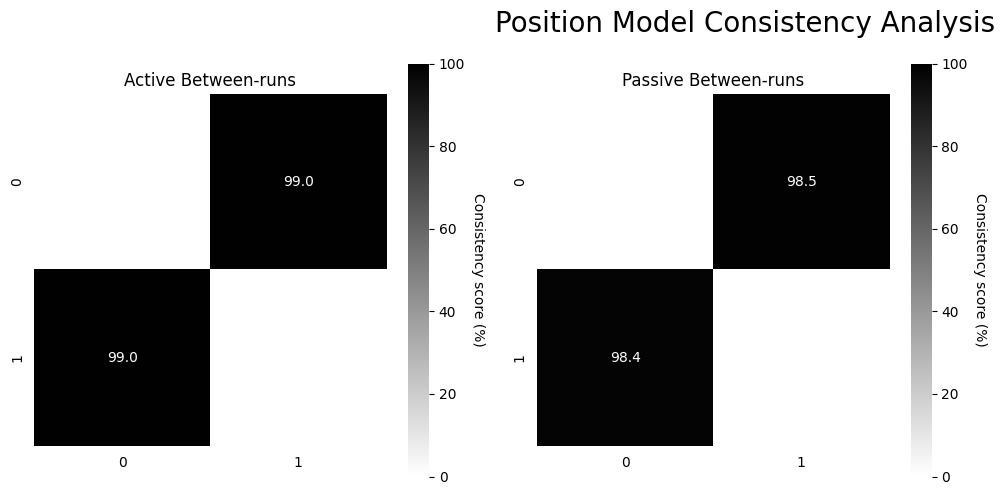

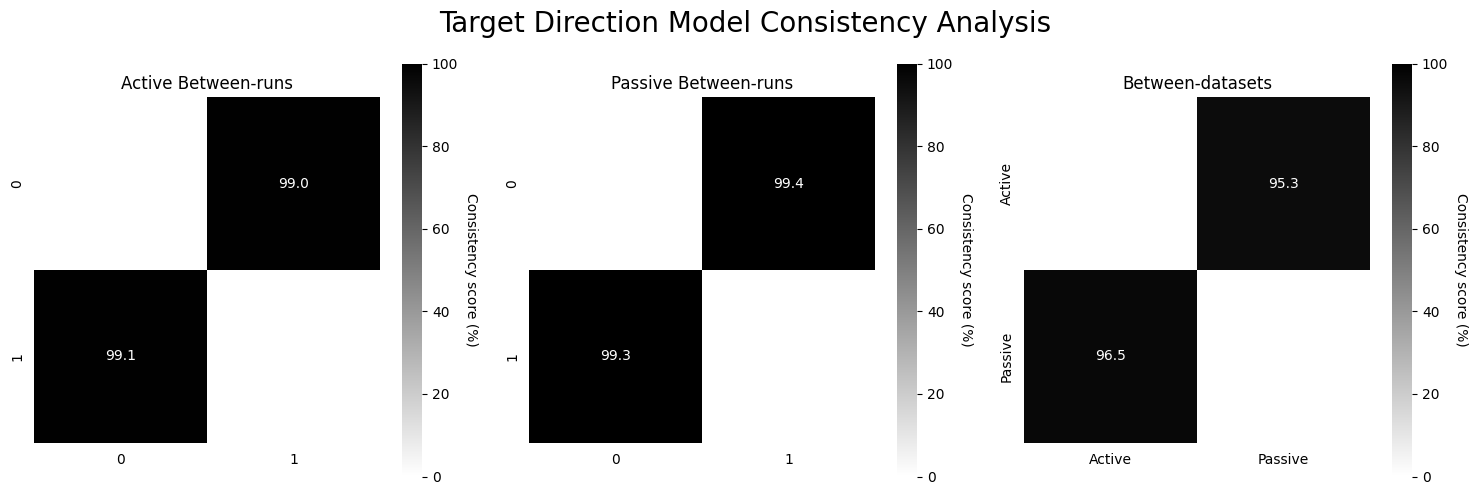

In [26]:
def plot_all_consistencies(consistency_results, title_prefix):
    """绘制所有一致性结果的可视化图"""
    fig = plt.figure(figsize=(15, 5))
    plt.suptitle(f'{title_prefix} Consistency Analysis', fontsize=20)
    
    # Active运行间一致性
    ax1 = fig.add_subplot(131)
    cebra.plot_consistency(
        consistency_results['runs1'][0],
        consistency_results['runs1'][1],
        consistency_results['runs1'][2],
        ax=ax1,
        title="Active Between-runs",
        vmin=0,
        vmax=100
    )
    
    # Passive运行间一致性
    ax2 = fig.add_subplot(132)
    cebra.plot_consistency(
        consistency_results['runs2'][0],
        consistency_results['runs2'][1],
        consistency_results['runs2'][2],
        ax=ax2,
        title="Passive Between-runs",
        vmin=0,
        vmax=100
    )
    
    # 数据集间一致性
    if consistency_results['datasets'][0] is not None:
        ax3 = fig.add_subplot(133)
        cebra.plot_consistency(
            consistency_results['datasets'][0],
            consistency_results['datasets'][1],
            ["Active", "Passive"],  # 使用更有意义的标签
            ax=ax3,
            title="Between-datasets",
            vmin=0,
            vmax=100
        )
    
    plt.tight_layout()
    plt.show()
    
    return fig

# 绘制位置模型的一致性结果
pos_consistency_fig = plot_all_consistencies(pos_consistency, "Position Model")

# 绘制目标方向模型的一致性结果
target_consistency_fig = plot_all_consistencies(target_consistency, "Target Direction Model")